In [509]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Module, Parameter
from torch.distributions.normal import Normal as NormalTorch
from torch.distributions.exponential import Exponential as ExpTorch
from torch.distributions.cauchy import Cauchy as CauchyTorch
import torch.optim as optim
import math

In [305]:
class Distribution(Module):
    
    def __init__(self):
        super(Distribution, self).__init__()
        
    def log_prob(self, x, *args):
        raise NotImplementedError("Log Prob Not Allowed")
        
    def sample(self, *args):
        raise NotImplementedError("Sampling Not Allowed")
        

In [568]:
class Normal(Distribution):
    
    def __init__(self, means=None, stds=None, dims=1):
        super(Normal, self).__init__()
        if means is None:
            self.mu = Parameter(torch.Tensor(dims).uniform_(-1, 1))
        else:
            self.mu = means
        if stds is None:
            self.std = Parameter(torch.Tensor(dims).uniform_(0, 1))
        else:
            self.std = stds
        
    def prob(self, x):
        prob = torch.exp(-((x-self.mu)**2) / (2*(self.std**2)))
        return (1.0 / torch.sqrt(2 * math.pi * (self.std**2))) * prob
        
    def log_prob(self, x):
        return torch.log(self.prob(x) + 1e-6)
    
    def _sample(self):
        return self.mu + self.std * torch.randn(self.std.size())
    
    def sample(self, n=1):
        return torch.stack([self._sample() for _ in range(n)])

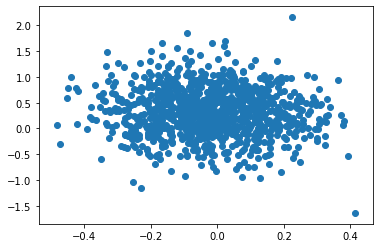

In [569]:
n = Normal(dims=2)
# plt.hist([n.sample().item() for _ in range(10000)], bins=100)
values = np.array([n.sample().detach().numpy()[0] for _ in range(1000)])
# plt.plot(n.sample()
plt.scatter(values[:, 0], values[:, 1])
plt.show()

In [570]:
def ForwardKL(samples, distribution):
    return -distribution.log_prob(samples).sum()

In [571]:
model = Normal(dims=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [572]:
samples = NormalTorch(torch.tensor([-3.0, 7.0]), torch.tensor([1.2, 3.54])).sample((1000,))
# samples = torch.normal(mean=torch.zeros(1000, 9).fill_(-2.5), 
#                        std=torch.ones(1000, 9).fill_(6.0))
samples

tensor([[-2.9487,  9.5504],
        [-4.0873,  7.4643],
        [-2.2067, 10.5332],
        ...,
        [-2.1323,  5.6347],
        [-1.2479,  6.1482],
        [-3.6672, 11.2796]])

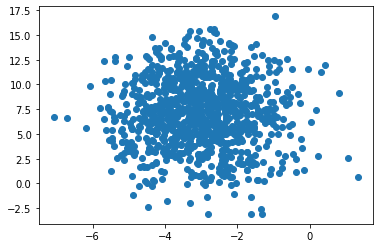

In [573]:
# model.log_prob(samples)
values = samples.numpy()
plt.scatter(values[:, 0], values[:, 1])
plt.show()

In [574]:
for i in range(3000):
    optimizer.zero_grad()

    loss = ForwardKL(samples, model)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

Epoch 0 Loss: 34223.539
Epoch 100 Loss: 12712.853
Epoch 200 Loss: 8113.556
Epoch 300 Loss: 6631.360
Epoch 400 Loss: 5884.071
Epoch 500 Loss: 5430.202
Epoch 600 Loss: 5126.554
Epoch 700 Loss: 4911.375
Epoch 800 Loss: 4753.527
Epoch 900 Loss: 4635.583
Epoch 1000 Loss: 4546.846
Epoch 1100 Loss: 4480.087
Epoch 1200 Loss: 4429.933
Epoch 1300 Loss: 4392.143
Epoch 1400 Loss: 4363.390
Epoch 1500 Loss: 4341.219
Epoch 1600 Loss: 4323.944
Epoch 1700 Loss: 4310.441
Epoch 1800 Loss: 4299.941
Epoch 1900 Loss: 4291.864
Epoch 2000 Loss: 4285.745
Epoch 2100 Loss: 4281.189
Epoch 2200 Loss: 4277.865
Epoch 2300 Loss: 4275.490
Epoch 2400 Loss: 4273.830
Epoch 2500 Loss: 4272.691
Epoch 2600 Loss: 4271.929
Epoch 2700 Loss: 4271.426
Epoch 2800 Loss: 4271.100
Epoch 2900 Loss: 4270.893


In [575]:
print(model.mu, model.std)

Parameter containing:
tensor([-3.0159,  7.0528], requires_grad=True) Parameter containing:
tensor([1.2074, 3.5161], requires_grad=True)


In [576]:
class Normal_No_Sample(Distribution):
    
    def __init__(self, means=None, stds=None, dims=1):
        super(Normal_No_Sample, self).__init__()
        if means is None:
            self.mu = torch.Tensor(dims).uniform_(-1, 1)
        else:
            self.mu = means
        if stds is None:
            self.std = torch.Tensor(dims).uniform_(0, 1)
        else:
            self.std = stds
        
    def prob(self, x):
        prob = torch.exp(-((x-self.mu)**2) / (2*(self.std**2)))
        return (1.0 / torch.sqrt(2 * math.pi * (self.std**2))) * prob
        
    def log_prob(self, x):
        return torch.log(self.prob(x) + 1e-6)

In [577]:
truth = Normal_No_Sample(torch.tensor([-3.0, 7.0]), torch.tensor([1.2, 3.54]))
model = Normal(dims=2)

print(truth.mu, truth.std)
print(model.mu, model.std)

tensor([-3.,  7.]) tensor([1.2000, 3.5400])
Parameter containing:
tensor([0.7616, 0.4288], requires_grad=True) Parameter containing:
tensor([0.8529, 0.0723], requires_grad=True)


In [679]:
def ReverseKL(q, p, i, batch_size=64):
    samples = q.sample(batch_size)
    if i % 100 == 0: print(p.log_prob(samples).sum(), q.log_prob(samples).sum())
    return -(p.log_prob(samples) - q.log_prob(samples)).sum()
    

In [579]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [580]:
for i in range(1500):
    optimizer.zero_grad()

    loss = ReverseKL(model, truth, 2, 128)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

Epoch 0 Loss: 1289.741
Epoch 100 Loss: 700.268
Epoch 200 Loss: 384.543
Epoch 300 Loss: 256.129
Epoch 400 Loss: 129.783
Epoch 500 Loss: 97.585
Epoch 600 Loss: 43.681
Epoch 700 Loss: 32.696
Epoch 800 Loss: 12.998
Epoch 900 Loss: 10.120
Epoch 1000 Loss: 12.906
Epoch 1100 Loss: 8.780
Epoch 1200 Loss: 5.638
Epoch 1300 Loss: 1.832
Epoch 1400 Loss: 2.000


In [581]:
print(truth.mu, truth.std)
print(model.mu, model.std)

tensor([-3.,  7.]) tensor([1.2000, 3.5400])
Parameter containing:
tensor([-3.0063,  6.9353], requires_grad=True) Parameter containing:
tensor([1.2072, 3.2506], requires_grad=True)


In [603]:
class Exponential(Distribution):
    def __init__(self, lamb=None):
        super(Exponential, self).__init__()
        if lamb is None:
            self.lamb = Parameter(torch.Tensor(1).uniform_(0, 3))
        else:
            self.lamb = lamb
        
    def log_prob(self, x):
        return torch.log(self.prob(x) + 1e-6)
    
    def prob(self, x):
        return self.lamb * torch.exp(-self.lamb * x)
    
    def _sample(self):
        return -torch.log(torch.rand(self.lamb.size())) / self.lamb #torch.log(1.0 / torch.rand(self.lamb.size()))
    
    def sample(self, n=1):
        return torch.stack([self._sample() for _ in range(n)])
    

class ExponentialNoSample(Distribution):
    def __init__(self, lamb=None):
        super(ExponentialNoSample, self).__init__()
        if lamb is None:
            self.lamb = torch.Tensor(1).uniform_(0, 3)
        else:
            self.lamb = lamb
        
    def log_prob(self, x):
        return torch.log(self.prob(x) + 1e-6)
    
    def prob(self, x):
        return self.lamb * torch.exp(-self.lamb * x)
    

In [617]:
torch_exp = ExpTorch(torch.tensor([0.5]))
model = Exponential()

print(model.lamb.item(), torch_exp.rate.item())



0.15021121501922607 0.5


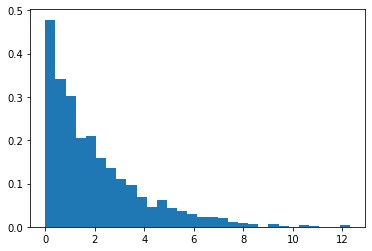

tensor(-1702.8976)
tensor(-2199.0647, grad_fn=<SumBackward0>)


In [618]:
samples = torch_exp.sample((1000,))
plt.hist(samples.reshape(-1), bins=30, density=True)
plt.show()

print(torch_exp.log_prob(samples).sum())
print(model.log_prob(samples).sum())

In [619]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(300):
    optimizer.zero_grad()
    loss = ForwardKL(samples, model)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

print("\nFinal Results")
print(model.lamb.item(), torch_exp.rate.item())

Epoch 0 Loss: 2199.065
Epoch 50 Loss: 1706.141
Epoch 100 Loss: 1702.850
Epoch 150 Loss: 1702.850
Epoch 200 Loss: 1702.851
Epoch 250 Loss: 1702.851

Final Results
0.49517202377319336 0.5


In [646]:
model = Exponential()
truth = ExponentialNoSample()

print(model.lamb.item(), truth.lamb.item(), "\n")

optimizer = optim.Adam(model.parameters(), lr=0.01)
for i in range(1700):
    optimizer.zero_grad()
    loss = ReverseKL(model, truth, 3)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")
        
print("\nFinal Results")
print(model.lamb.item(), truth.lamb.item())

0.1838235855102539 2.5957398414611816 

Epoch 0 Loss: 515.622
Epoch 100 Loss: 132.486
Epoch 200 Loss: 31.894
Epoch 300 Loss: 30.803
Epoch 400 Loss: 11.868
Epoch 500 Loss: 31.299
Epoch 600 Loss: 20.551
Epoch 700 Loss: 11.845
Epoch 800 Loss: 4.974
Epoch 900 Loss: -3.495
Epoch 1000 Loss: 4.414
Epoch 1100 Loss: 5.176
Epoch 1200 Loss: 0.898
Epoch 1300 Loss: 4.553
Epoch 1400 Loss: 1.297
Epoch 1500 Loss: 0.911
Epoch 1600 Loss: -1.002

Final Results
2.2370872497558594 2.5957398414611816


In [651]:
class Cauchy(Distribution):
    def __init__(self, loc=None, scale=None, dims=1):
        super(Cauchy, self).__init__()
        if loc is None:
            self.loc = Parameter(torch.Tensor(dims).uniform_(-1, 1))
        else:
            self.loc = loc
        if scale is None:
            self.scale = Parameter(torch.Tensor(dims).uniform_(0, 1))
        else:
            self.scale = scale
        
    def log_prob(self, x):
        return torch.log(self.prob(x) + 1e-3)
    
    def prob(self, x):
        return 1.0 / (math.pi * self.scale * (1.0 + ((x - self.loc) / self.scale)**2 ))
    
    def _sample(self):
        return self.loc + self.scale * torch.tan(math.pi * (torch.rand(self.loc.size()) - 0.5))
    
    def sample(self, n=1):
        return torch.stack([self._sample() for _ in range(n)])
    

class CauchyNoSample(Distribution):
    def __init__(self, loc=None, scale=None, dims=1):
        super(CauchyNoSample, self).__init__()
        if loc is None:
            self.loc = torch.Tensor(dims).uniform_(-1, 1)
        else:
            self.loc = loc
        if scale is None:
            self.scale = torch.Tensor(dims).uniform_(0, 1)
        else:
            self.scale = scale
        
    def log_prob(self, x):
        return torch.log(self.prob(x) + 1e-3)
    
    def prob(self, x):
        return 1.0 / (math.pi * self.scale * (1.0 + ((x - self.loc) / self.scale)**2 ))
    

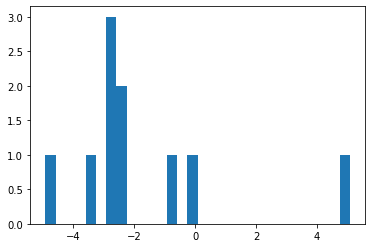

In [652]:
real_cauchy = CauchyTorch(torch.tensor([-2.0]), torch.tensor([1.0]))
model = Cauchy(torch.tensor([-2.0]), torch.tensor([1.0]))


samples = model.sample(10)
plt.hist(samples.reshape(-1), bins=30)
plt.show()

In [653]:
real_cauchy = CauchyTorch(torch.tensor([-2.0]), torch.tensor([1.0]))
model = Cauchy()

print(real_cauchy.loc.item(), real_cauchy.scale.item(), "\n")
print(model.loc.item(), model.scale.item(), "\n")

optimizer = optim.Adam(model.parameters(), lr=0.01)

samples = real_cauchy.sample((1000,))

for i in range(600):
    optimizer.zero_grad()
    loss = ForwardKL(samples, model)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

print("\nFinal Results")
print(model.loc.item(), model.scale.item(), "\n")

-2.0 1.0 

-0.8389104604721069 0.9005265831947327 

Epoch 0 Loss: 2769.813
Epoch 100 Loss: 2467.787
Epoch 200 Loss: 2431.966
Epoch 300 Loss: 2431.869
Epoch 400 Loss: 2431.869
Epoch 500 Loss: 2431.869

Final Results
-2.0169785022735596 0.8861351609230042 



In [680]:
real_cauchy = CauchyNoSample(torch.tensor([0.0]), torch.tensor([1.0]))
model = Cauchy()

print(real_cauchy.loc.item(), real_cauchy.scale.item(), "\n")
print(model.loc.item(), model.scale.item(), "\n")

optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(1500):
    optimizer.zero_grad()
#     print(model.loc.item(), model.scale.item(), "\n")
    loss = ReverseKL(model, truth, 100)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")
        
print("\nFinal Results")
print(model.loc.item(), model.scale.item(), "\n")

0.0 1.0 

-0.7805041074752808 0.046771109104156494 

tensor(189.0551, grad_fn=<SumBackward0>) tensor(61.6153, grad_fn=<SumBackward0>)
Epoch 0 Loss: -127.440
tensor(223.0620, grad_fn=<SumBackward0>) tensor(36.2136, grad_fn=<SumBackward0>)
tensor(177.6834, grad_fn=<SumBackward0>) tensor(23.7605, grad_fn=<SumBackward0>)
tensor(199.1813, grad_fn=<SumBackward0>) tensor(14.9608, grad_fn=<SumBackward0>)
tensor(198.2908, grad_fn=<SumBackward0>) tensor(-19.1745, grad_fn=<SumBackward0>)
tensor(194.2052, grad_fn=<SumBackward0>) tensor(6.9108, grad_fn=<SumBackward0>)
tensor(234.5733, grad_fn=<SumBackward0>) tensor(-15.1687, grad_fn=<SumBackward0>)
tensor(248.7543, grad_fn=<SumBackward0>) tensor(-27.8453, grad_fn=<SumBackward0>)
tensor(190.8489, grad_fn=<SumBackward0>) tensor(-14.2291, grad_fn=<SumBackward0>)
tensor(inf, grad_fn=<SumBackward0>) tensor(-37.5427, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
Epoch 800 Loss: nan
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(n

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
Epoch 1200 Loss: nan
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>) tensor(nan, grad_fn=<SumBack

In [663]:
model = Cauchy()
print(model.loc, model.scale)

Parameter containing:
tensor([-0.4842], requires_grad=True) Parameter containing:
tensor([0.3207], requires_grad=True)
